作業1：

使用 TensorFlow 或 PyTorch 實作類神經網路模型預測股票價格（TensorFlow 使用 Dense layer；PyTorch 使用 Linear layer）。
說明：使用收盤價或技術指標預測，預測N日後的股價。

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 設定股票代號與時間範圍
stock_id = '2330.TW'
end = dt.date.today()
start = end - dt.timedelta(days=360)
df_stat = yf.download(stock_id, start=start, end=end)

# 新增移動平均線和其他技術指標
df_stat['SMA_5'] = df_stat['Close'].rolling(window=5).mean()
df_stat['SMA_20'] = df_stat['Close'].rolling(window=20).mean()
df_stat['RSI'] = 100 - (100 / (1 + df_stat['Close'].diff().gt(0).rolling(14).sum() /
                                 df_stat['Close'].diff().lt(0).rolling(14).sum()))
df_stat = df_stat.dropna()

# 設定特徵 (Close, SMA_5, SMA_20, RSI)
features = df_stat[['Close', 'SMA_5', 'SMA_20', 'RSI']].values

# 定義窗口大小
N = 5  # 使用前 N 天的數據

# 準備數據集，將每個樣本擴展為包含前 N 天的數據
def create_sequences(features, labels, N):
    X, y = [], []
    for i in range(N, len(features)):
        X.append(features[i-N:i])  # 前 N 天的特徵
        y.append(labels[i])        # 第 i 天的標籤
    return np.array(X), np.array(y)

# 使用特徵進行標準化
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)

# 對標籤（收盤價）進行標準化
label_scaler = MinMaxScaler()
scaled_labels = label_scaler.fit_transform(df_stat['Close'].values.reshape(-1, 1))

# 構建序列數據
X, y = create_sequences(scaled_features, scaled_labels, N)

# 分割訓練和測試數據
train_size = int(len(X) * 0.7)
train_features, test_features = X[:train_size], X[train_size:]
train_labels, test_labels = y[:train_size], y[train_size:]

# 將數據轉換為 tensor 格式
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32).squeeze()
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32).squeeze()

# 檢查數據形狀
print("train_features shape:", train_features.shape)  # 應該是 (樣本數量, N, 特徵數量)
print("train_labels shape:", train_labels.shape)
print("test_features shape:", test_features.shape)
print("test_labels shape:", test_labels.shape)

[*********************100%***********************]  1 of 1 completed

train_features shape: torch.Size([150, 5, 4])
train_labels shape: torch.Size([150])
test_features shape: torch.Size([65, 5, 4])
test_labels shape: torch.Size([65])


In [ ]:
# 定義模型
class StockPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StockPredictor, self).__init__()
        self.linear = nn.Linear(input_dim * N, output_dim)  # 將窗口的每個特徵展開到單層線性層

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平輸入的窗口特徵
        return self.linear(x)

# 模型、損失函數和優化器
model = StockPredictor(train_features.shape[2], 1)  # 設定模型輸入大小
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [20/200], Loss: 0.1138
Epoch [40/200], Loss: 0.0575
Epoch [60/200], Loss: 0.0425
Epoch [80/200], Loss: 0.0348
Epoch [100/200], Loss: 0.0279
Epoch [120/200], Loss: 0.0219
Epoch [140/200], Loss: 0.0170
Epoch [160/200], Loss: 0.0130
Epoch [180/200], Loss: 0.0099
Epoch [200/200], Loss: 0.0075


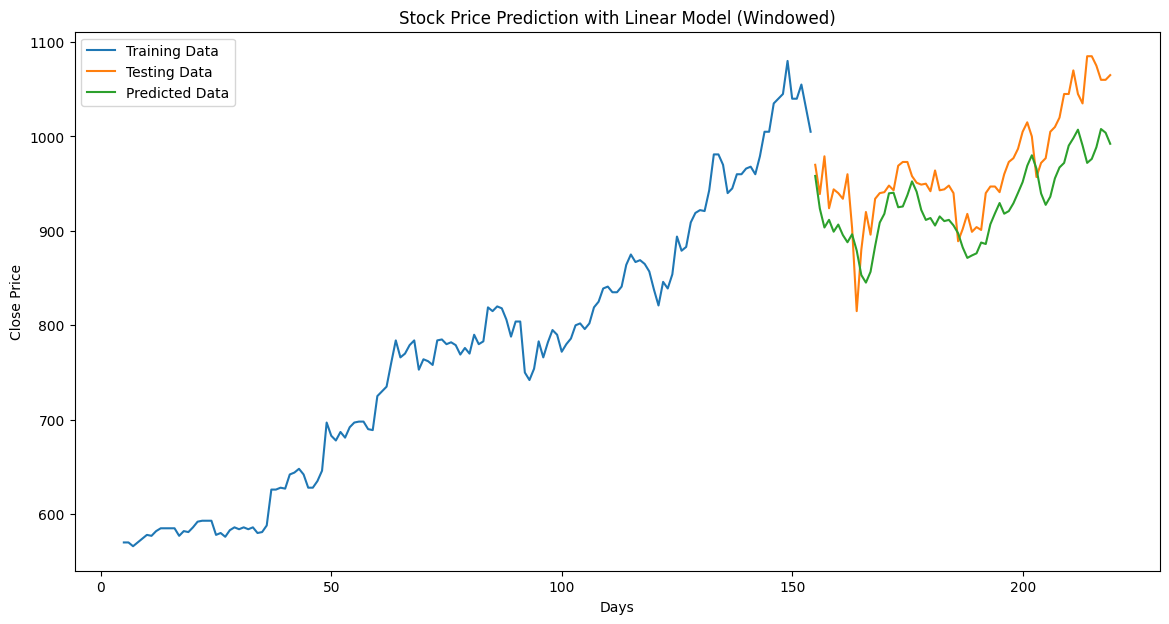

In [ ]:
# 訓練模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features).squeeze()
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 測試模型並反向縮放預測結果
with torch.no_grad():
    predicted = model(test_features).squeeze()
    predicted = label_scaler.inverse_transform(predicted.numpy().reshape(-1, 1)).flatten()
    test_labels_original = label_scaler.inverse_transform(test_labels.reshape(-1, 1)).flatten()
    train_labels_original = label_scaler.inverse_transform(train_labels.reshape(-1, 1)).flatten()

# 繪圖顯示
plt.figure(figsize=(14, 7))
plt.plot(range(N, len(train_labels_original) + N), train_labels_original, label='Training Data')
plt.plot(range(len(train_labels_original) + N, len(train_labels_original) + N + len(test_labels_original)), test_labels_original, label='Testing Data')
plt.plot(range(len(train_labels_original) + N, len(train_labels_original) + N + len(predicted)), predicted, label='Predicted Data')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction with Linear Model (Windowed)')
plt.show()

作業2：

使用 TensorFlow 或 PyTorch 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌（分類任務）。
說明：輸入一張 N 天的 K 線圖判斷未來價格可能漲或跌，label 方式可以使用技術指標輔助，例如：5日均線高於10日均線標註「漲」，5日均線低於10日均線標註「跌」。

步驟一：資料標記

首先，我們需要根據 5 日和 10 日均線生成標籤。

In [ ]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np

# 設定股票代號與時間範圍
stock_id = '2330.TW'
end = dt.date.today()
start = end - dt.timedelta(days=180)
df_stat = yf.download(stock_id, start=start, end=end)

# 新增移動平均線和標籤
df_stat['SMA_5'] = df_stat['Close'].rolling(window=5).mean()
df_stat['SMA_10'] = df_stat['Close'].rolling(window=10).mean()

# 標記漲跌（1 表示漲，0 表示跌）
df_stat['Label'] = np.where(df_stat['SMA_5'] > df_stat['SMA_10'], 1, 0)
df_stat = df_stat.dropna()  # 去除 NA 值

[*********************100%***********************]  1 of 1 completed


步驟二：生成 K 線圖並保存為影像

使用 matplotlib 將每個 N 天窗口的 K 線圖保存為影像，供 CNN 使用。這裡假設 N = 20 天。

In [ ]:
import matplotlib.pyplot as plt
import os

# 確保標籤僅為 0 或 1
df_stat['Label'] = np.where(df_stat['SMA_5'] > df_stat['SMA_10'], 1, 0)
df_stat = df_stat.dropna()  # 去除 NA 值

# 設置影像保存資料夾
output_dir = 'k_line_images'
os.makedirs(output_dir, exist_ok=True)

N = 20  # 設定窗口大小
for i in range(N, len(df_stat)):
    window_data = df_stat.iloc[i-N:i]
    label = int(df_stat.iloc[i]['Label'])  # 獲取標籤，確保為整數型態 0 或 1

    # 畫出 K 線圖
    fig, ax = plt.subplots()
    ax.plot(window_data.index, window_data['Close'], color='black', lw=2)
    ax.plot(window_data.index, window_data['SMA_5'], color='blue', linestyle='--', label='SMA_5')
    ax.plot(window_data.index, window_data['SMA_10'], color='red', linestyle='--', label='SMA_10')
    ax.legend()

    # 保存影像，使用正確的檔案名稱格式
    file_path = os.path.join(output_dir, f"{i}_label_{label}.png")
    plt.savefig(file_path, bbox_inches='tight')  # 確保只保存圖像本身
    plt.close(fig)

print("K 線圖影像已保存到資料夾:", output_dir)

<ipython-input-2-f36bef52ae9c>:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(df_stat.iloc[i]['Label'])  # 獲取標籤，確保為整數型態 0 或 1


K 線圖影像已保存到資料夾: k_line_images


步驟三：建立 CNN 模型

定義 CNN 模型結構，將影像作為輸入進行分類。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# 自訂資料集類別
class KLineDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = int(img_name.split('_')[-1].split('.')[0])  # 提取標籤
        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# 定義 CNN 模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 25 * 25, 128)  # 根據輸出形狀調整線性層大小
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平輸出
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 設定資料增強和資料載入
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # 調整影像大小
    transforms.ToTensor()
])

dataset = KLineDataset(image_dir='k_line_images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 模型、損失函數和優化器
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

Epoch [1/10], Loss: 1.9125
Epoch [2/10], Loss: 0.6802
Epoch [3/10], Loss: 0.6806
Epoch [4/10], Loss: 0.6784
Epoch [5/10], Loss: 0.6635
Epoch [6/10], Loss: 0.6666
Epoch [7/10], Loss: 0.6446
Epoch [8/10], Loss: 0.6677
Epoch [9/10], Loss: 0.6560
Epoch [10/10], Loss: 0.6569


In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


<ipython-input-20-d99425ecb837>:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  actual_label = int(df_stat.iloc[i]['Label'])  # 確保單一元素的標籤提取


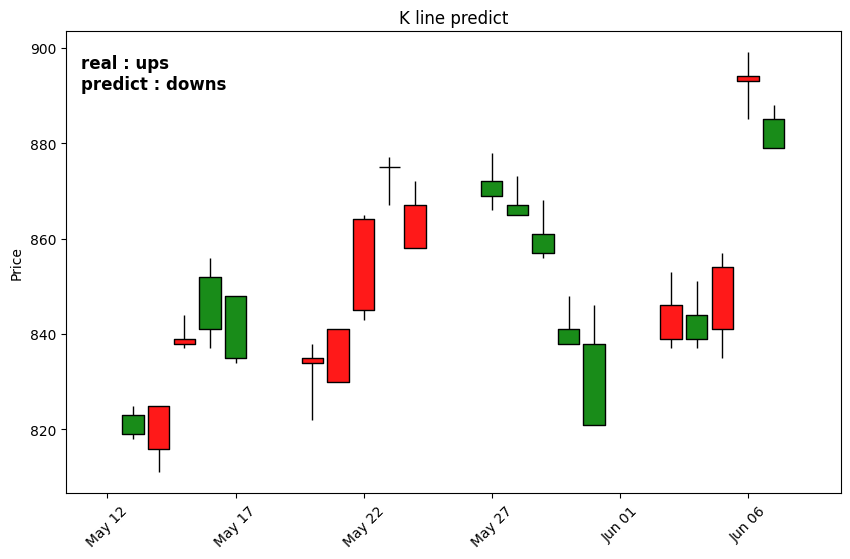

<ipython-input-20-d99425ecb837>:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  actual_label = int(df_stat.iloc[i]['Label'])  # 確保單一元素的標籤提取


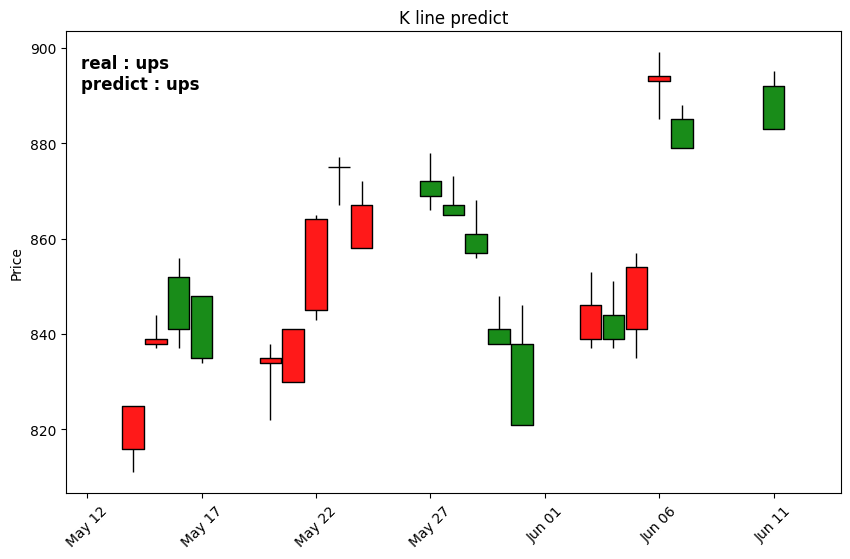

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd

# 設定窗口大小
N = 20

# 循環每個窗口來畫 K 線圖並進行預測
for i in range(N, len(df_stat)):
    # 提取窗口數據並移除多層索引，確保只有 'Open', 'High', 'Low', 'Close'
    window_data = df_stat.iloc[i-N:i][['Open', 'High', 'Low', 'Close']]
    window_data.columns = ['Open', 'High', 'Low', 'Close']  # 重新命名列
    window_data = window_data.apply(pd.to_numeric, errors='coerce').dropna()  # 確保數據為浮點數並去除 NaN

    # 獲取實際結果標籤
    actual_label = int(df_stat.iloc[i]['Label'])  # 確保單一元素的標籤提取

    # 假設模型預測結果為「漲」（1），這裡使用隨機值作為示範
    predicted_label = np.random.choice([0, 1])

    # 定義 K 線圖的顏色樣式
    mc = mpf.make_marketcolors(up='red', down='green', wick='black', edge='black')
    s = mpf.make_mpf_style(marketcolors=mc)

    # 繪製 K 線圖
    fig, ax = plt.subplots(figsize=(10, 6))
    mpf.plot(window_data, type='candle', style=s, ax=ax, show_nontrading=True)

    # 添加「實際結果」和「預測結果」的文字標示
    actual_text = "ups" if actual_label == 1 else "downs"
    predicted_text = "ups" if predicted_label == 1 else "downs"
    plt.text(0.02, 0.95, f"real : {actual_text}\npredict : {predicted_text}",
             transform=ax.transAxes, fontsize=12, verticalalignment='top', fontweight='bold')

    # 顯示圖像
    plt.title("K line predict")
    plt.show()

    # 控制顯示的圖像數量
    if i >= N + 1:  # 只顯示前 2 個作為範例
        break